# Homework 3

Your name: Jiaxuan Zhang

Your Andrew ID: jiaxuanz

Collaborators (if none, say \"none\"; do *not* leave this blank):

# Part 1: Email spam classification [30 points]

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

**(a) Print the number of ham and spam emails [1 point]**

In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it? (You do *not* have to implement what you suggest here for later parts of the problem.)

In [195]:
import glob
print('The number of ham emails in training data: %d' % len(glob.glob('./email-data/ham/*.txt')))
print('The number of spam emails in training data: %d' % len(glob.glob('./email-data/spam/*.txt')))

The number of ham emails in training data: 1500
The number of spam emails in training data: 3671


**Your answers to the above questions:**

1. This training dataset is imbalanced because the number of spam eamils is almost 2.5 times than ham emails. This will be problematic in training the model.
2. There are several ways to address the imbalanced problem:

    a. Increase the dataset size by generating synthetic data for ham emails
    b. Use some other evaluation criterion, such as AOC curve
    c. Try to divide spam emails into sub sample

**(b) Construct the documents [4 points]**
 
   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [196]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [197]:
import numpy as np
train_emails, train_labels = [], []
for ham in glob.glob('./email-data/ham/*.txt'):
    train_emails.append(makeWordList(ham))
    train_labels.append(0)

for spam in glob.glob('./email-data/spam/*.txt'):
    train_emails.append(makeWordList(spam))
    train_labels.append(1)
train_labels = np.array(train_labels)

**(c) Construct the document matrix `X` as a matrix of word frequencies [5 points]**

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [198]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english", min_df=50, max_df=0.8)
train_X = vectorizer.fit_transform(train_emails)
print(len(vectorizer.vocabulary_))

1680


**(d) k-NN and random forest: Hyperparameter selection [10 points]**

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - Random forest: Select `max_features` **and** `min_samples_leaf` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_max_features`, and `best_min_samples_leaf` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [199]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import numpy as np
import warnings 
warnings.filterwarnings("ignore") 

num_folds = 5
k_fold = KFold(num_folds)

def hyperparam_select(model, hyperparameter_settings):
    best_hyperparam_setting = None
    best_cross_val_score = -np.inf  # assumes that a higher score is better
    
    for hyperparameter in hyperparameter_settings:
        fold_scores = []
        for train_indices, val_indices in k_fold.split(train_X):
            if model == 'KNN':
                classifier = KNeighborsClassifier(n_neighbors=hyperparameter)
            elif model == 'RANDOM_FOREST':
                classifier = RandomForestClassifier(n_estimators=hyperparameter[0],
                                                max_depth=hyperparameter[1],
                                                random_state=0)
            classifier.fit(train_X[train_indices], train_labels[train_indices])
            predicted_val_labels = classifier.predict(train_X[val_indices])
            score = f1_score(train_labels[val_indices], predicted_val_labels, average='weighted')
            fold_scores.append(score)
            
        cross_val_score = np.mean(fold_scores)
        print('hyperparameter: ', hyperparameter, ' ', cross_val_score)
        if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
            best_cross_val_score = cross_val_score
            best_hyperparam_setting = hyperparameter

    print('Best hyperparameter setting:', best_hyperparam_setting)
    return(best_hyperparam_setting)

In [200]:
# for KNN
hyperparameter_settings = [k for k in range(1, 10)]
best_k = hyperparam_select('KNN', hyperparameter_settings)

hyperparameter:  1   0.8935568948752601
hyperparameter:  2   0.8676994450420699
hyperparameter:  3   0.908802205187763
hyperparameter:  4   0.9022154795679619
hyperparameter:  5   0.8945889226049388
hyperparameter:  6   0.8962351045294874
hyperparameter:  7   0.8824264408619922
hyperparameter:  8   0.8846749403078166
hyperparameter:  9   0.8764849450467521
Best hyperparameter setting: 3


In [203]:
# for Random Forest
hyperparameter_settings = [(num_trees, max_depth) for num_trees in range(50, 300, 50) for max_depth in (None, 4, 8, 12, 16)]
best_n_estimators, best_max_depth = hyperparam_select('RANDOM_FOREST', hyperparameter_settings)


hyperparameter:  (50, None)   0.9760540166897161
hyperparameter:  (50, 4)   0.841165416281967
hyperparameter:  (50, 8)   0.8982107974076227
hyperparameter:  (50, 12)   0.926655122082974
hyperparameter:  (50, 16)   0.9470317792320124
hyperparameter:  (100, None)   0.9773225292950395
hyperparameter:  (100, 4)   0.8366951566199929
hyperparameter:  (100, 8)   0.8886559365923752
hyperparameter:  (100, 12)   0.9238480412499515
hyperparameter:  (100, 16)   0.9455670232847625
hyperparameter:  (150, None)   0.9773099140624357
hyperparameter:  (150, 4)   0.8361042100065139
hyperparameter:  (150, 8)   0.8855020234372173
hyperparameter:  (150, 12)   0.9213131178790075
hyperparameter:  (150, 16)   0.9429835704937167
hyperparameter:  (200, None)   0.9774300225066096
hyperparameter:  (200, 4)   0.8360500134262537
hyperparameter:  (200, 8)   0.8856293297615258
hyperparameter:  (200, 12)   0.9207908890669427
hyperparameter:  (200, 16)   0.9413579908427268
hyperparameter:  (250, None)   0.97762695872052

**(e) Classifier testing: Precision-Recall and ROC curves [10 points]**

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the full training data.
   - Use test emails in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 2 ROC curves, one for each classifier. (We vary the threshold probability of declaring an email to be spam to obtain these plots.)
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 2 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier using the sklearn function [`average_precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score); average precision is essentially an approximation of the area under the precision-recall curve that avoids being overly optimistic.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

In [201]:
test_emails, test_labels = [], []
for email in glob.glob('./email-data/testing/*.txt'):
    test_emails.append(makeWordList(email))
    if 'spam' in email:
        test_labels.append(1)
    elif 'ham' in email:
        test_labels.append(0)

test_X = vectorizer.transform(test_emails)
test_labels = np.array(test_labels)

In [208]:
from sklearn import metrics

#Train the KNN model
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier.fit(train_X, train_labels)

knn_predict_scores = knn_classifier.predict_proba(test_X)[:, 1]
knn_fpr, knn_tpr, knn_thresholds = metrics.roc_curve(test_labels, knn_predict_scores)
knn_auc = metrics.auc(knn_fpr, knn_tpr)
knn_precision, knn_recall, knn_thresholds = metrics.precision_recall_curve(test_labels, knn_predict_scores)
knn_avg_pre = metrics.average_precision_score(test_labels, knn_predict_scores)

# Train the random forest model
rf_classifier = RandomForestClassifier(n_estimators=best_n_estimators,
                                                max_depth=best_max_depth,
                                                random_state=0)
rf_classifier.fit(train_X, train_labels)

rf_predict_scores = rf_classifier.predict_proba(test_X)[:, 1]
rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(test_labels, rf_predict_scores)
rf_auc = metrics.auc(rf_fpr, rf_tpr)

rf_precision, rf_recall, rf_thresholds = metrics.precision_recall_curve(test_labels, rf_predict_scores)
rf_avg_pre = metrics.average_precision_score(test_labels, rf_predict_scores)


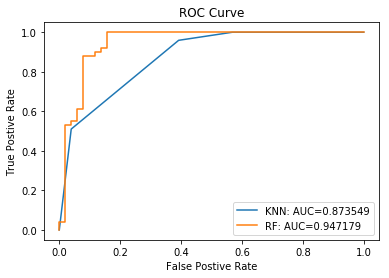

In [209]:
# AUC curve visualization
import matplotlib.pyplot as plt
plt.plot(knn_fpr, knn_tpr, label=('KNN: AUC=%f' % knn_auc))
plt.plot(rf_fpr, rf_tpr, label=('RF: AUC=%f' % rf_auc))
plt.legend()
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.title('ROC Curve')
plt.show()


<function matplotlib.pyplot.show(*args, **kw)>

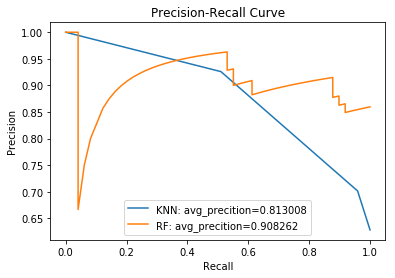

In [210]:
# Precision-Recall curve visualization
plt.plot(knn_recall, knn_precision, label=('KNN: avg_precition=%f' % knn_avg_pre))
plt.plot(rf_recall, rf_precision, label=('RF: avg_precition=%f' % rf_avg_pre))
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show

**Your answers to the above questions:**

For the first question, I will use ROC curve instead of PR curve for this problem. This is because the number of positive lable is much more than the number of negative label, which influences the precision to some extent.

For the second problem, I will use the random forest model for this problem because of the higher AUC value and better ROC curve.

# Part 2: Representation Learning [40 points]

Before getting started, please put the attached file `pretrained_convnet.pt` in the same directory as this notebook.

Recall from lecture the "crumpled paper analogy": in a neural net, as you progress through the layers from input to output, the layers should be "unfolding the original space" to disentangle the classes. When you get to the layer before the classifier, you should've changed the data representation into something that makes classification easy. **We will refer to the layer before the classifier in the neural net as the bottleneck layer.**

In this problem, you will be using an output of a bottleneck layer from pre-trained CNN as input features for a few simple classifiers. The CNN provided was trained with the Fashion MNIST dataset which consists of 10 classes of 28x28 grayscale images; this dataset is very similar to MNIST in that there are 10 classes with images that are the same size as MNIST and in fact even the training and test set sizes are the same (60,000 and 10,000 respectively). However, the classes are not the digits 0 through 9. Instead the classes are:

| Class | Description |
| ----- | :---------: |
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Let's start with some imports.

In [216]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummaryX import summary

from UDA_pytorch_utils import UDA_LSTMforSequential, UDA_pytorch_classifier_fit, \
        UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
        UDA_pytorch_model_transform, UDA_compute_accuracy

**Loading in the data.** We first load the Fashion MNIST dataset and plot some example images.

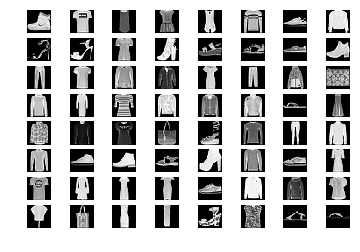

In [217]:
# do not modify this cell
train_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                  train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)

train_images = torch.tensor([image.numpy() for image, label in train_dataset])
train_labels = torch.tensor([label for image, label in train_dataset])

test_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                 train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

test_images = torch.tensor([image.numpy() for image, label in test_dataset])
test_labels = torch.tensor([label for image, label in test_dataset])

# show some of the first training images
square_grid_num_rows = 8
num_images_to_show = square_grid_num_rows ** 2
for idx in range(num_images_to_show):
    plt.subplot(square_grid_num_rows, square_grid_num_rows, idx + 1)
    plt.imshow(train_images[idx][0], cmap='gray')
    plt.axis('off')

**(a) [5 points]** Select train and test data that belong to classes 2 (corresponding to pullovers) or 6 (corresponding to fancier shirts than t-shirts; note: class 0 corresponds to t-shirts), i.e., subsample all the data that has label 2 or 6. Save the variables as `x_train`, `x_test`, `y_train`, `y_test`. From now on, we are only dealing with the images that are in classes 2 (pullovers) or 6 (shirts). Moreover, in `y_train` and `y_test`, please renumber the two classes so that pullovers now instead corresponds to 0 and shirts corresponds to 1 (we will consider shirts to be the "positive" class and pullovers to be the "negative" class).

In [218]:
x_train = torch.tensor([image.numpy() for image, label in train_dataset if label == 2 or label == 6])
y_train = [label for image, label in train_dataset if label == 2 or label == 6]
y_train = torch.tensor([1 if label == 6 else 0 for label in y_train])

x_test = torch.tensor([image.numpy() for image, label in test_dataset if label == 2 or label == 6])
y_test = [label for image, label in test_dataset if label == 2 or label == 6]
y_test = torch.tensor([1 if label == 6 else 0 for label in y_test])

We will make some t-SNE visualizations shortly and using all the training data will be too slow. We reduce the size of the training dataset by randomly subsampling 1000 samples from `x_train`/`y_train` pairs and saving the subsampled versions as `x_train_small`/`y_train_small` (the i-th image in `x_train_small` should have its label given by the i-th entry in `y_train_small`). We have provided the indices of which 1000 samples to use (from within `x_train`/`y_train`).

In [219]:
# do not modify this cell
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([12000, 1, 28, 28]) torch.Size([12000])
torch.Size([2000, 1, 28, 28]) torch.Size([2000])


In [220]:
# do not modify this cell
np.random.seed(0)
random_sample = np.random.permutation(len(x_train))[:1000]

In [221]:
x_train_small = x_train[random_sample]
y_train_small = y_train[random_sample]

**(b) [9 points]** We are ready to load the pre-trained convnet. The bottleneck layer is right before the final linear layer and corresponds to the output of a ReLU that has 84 values. **We refer to the output of this ReLU as the bottleneck feature vector representation of whatever the input is.**

Note that the convnet was pre-trained using the entire training dataset which consists of 60,000 samples and all 10 labels.

In [222]:
# load the pre-trained CNN
convnet = nn.Sequential(nn.Conv2d(1, 6, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(6, 16, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(in_features=16 * 5 * 5, out_features=120),
                        nn.ReLU(),
                        nn.Linear(in_features=120, out_features=84),
                        nn.ReLU(),
                        nn.Linear(in_features=84, out_features=10))
convnet.load_state_dict(torch.load('pretrained_convnet.pt', map_location=torch.device('cpu')))
convnet.eval()
print('[Summary of pre-trained convnet]')
summary(convnet, torch.zeros((1, 1, 28, 28)))
print()

# select the pretrained CNN upto the bottleneck layer
intermediate_layer_model = convnet[:-1]
print('[Summary of the pre-trained convnet up to the bottleneck layer]')
summary(intermediate_layer_model, torch.zeros((1, 1, 28, 28)))

[Summary of pre-trained convnet]
        Kernel Shape     Output Shape   Params Mult-Adds
Layer                                                   
0_0     [1, 6, 3, 3]   [1, 6, 26, 26]     60.0   36.504k
1_1                -   [1, 6, 26, 26]        -         -
2_2                -   [1, 6, 13, 13]        -         -
3_3    [6, 16, 3, 3]  [1, 16, 11, 11]    880.0  104.544k
4_4                -  [1, 16, 11, 11]        -         -
5_5                -    [1, 16, 5, 5]        -         -
6_6                -         [1, 400]        -         -
7_7       [400, 120]         [1, 120]   48.12k     48.0k
8_8                -         [1, 120]        -         -
9_9        [120, 84]          [1, 84]  10.164k    10.08k
10_10              -          [1, 84]        -         -
11_11       [84, 10]          [1, 10]    850.0     840.0
---------------------------------------------------------
                        Totals
Total params           60.074k
Trainable params       60.074k
Non-trainable para

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[1, 6, 3, 3]","[1, 6, 26, 26]",60.0,36504.0
1_1,-,"[1, 6, 26, 26]",NaN,NaN
2_2,-,"[1, 6, 13, 13]",NaN,NaN
3_3,"[6, 16, 3, 3]","[1, 16, 11, 11]",880.0,104544.0
4_4,-,"[1, 16, 11, 11]",NaN,NaN
5_5,-,"[1, 16, 5, 5]",NaN,NaN
6_6,-,"[1, 400]",NaN,NaN
7_7,"[400, 120]","[1, 120]",48120.0,48000.0
8_8,-,"[1, 120]",NaN,NaN


We first extract bottleneck feature vectors of the subsampled 1000 training data from the intermediate model.

In [223]:
# do not modify this cell
x_train_small_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train_small)

Next, visualize two different types of features with t-SNE.

1. Make a t-SNE plot using the **784 (=28$\times$28) dimensional raw features** from the subsampled training data (i.e., using `x_train_small`). Set `n_components=2, verbose=1, perplexity=25, random_state=0` for `TSNE` from scikit-learn. Plot the two classes in different colors.

2. Repeat the previous step (using the exact same arguments for `TSNE`) except now using the **84 dimensional bottleneck features** (i.e., using `x_train_small_bottleneck_representation`.

You may need to convert between PyTorch tensors and NumPy arrays.

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.027s...
[t-SNE] Computed neighbors for 1000 samples in 1.587s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.929497
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.569519
[t-SNE] KL divergence after 1000 iterations: 1.074359


Text(0.5, 1.0, 'T-SNE Plot for Raw Features')

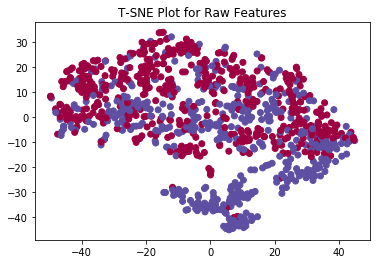

In [224]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=25, random_state=0)

flattened_x_train_small = x_train_small.reshape(x_train_small.shape[0], -1)

feature_vectors_tsne2d = tsne.fit_transform(flattened_x_train_small)

plt.scatter(feature_vectors_tsne2d[:, 0], feature_vectors_tsne2d[:, 1],
            c=np.array(y_train_small), cmap='Spectral')
plt.title('T-SNE Plot for Raw Features')

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.004s...
[t-SNE] Computed neighbors for 1000 samples in 0.166s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.053075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.145187
[t-SNE] KL divergence after 1000 iterations: 0.993664


Text(0.5, 1.0, 'T-SNE Plot for Bottleneck Features')

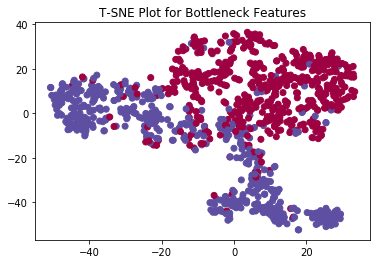

In [225]:
feature_vectors_tsne2d = tsne.fit_transform(x_train_small_bottleneck_representation)

plt.scatter(feature_vectors_tsne2d[:, 0], feature_vectors_tsne2d[:, 1],
            c=np.array(y_train_small), cmap='Spectral')
plt.title('T-SNE Plot for Bottleneck Features')

**(c) [16 points]** We now evaluate on test data and compare several different classifiers. Train **5-NN** and **random forest** classifiers with **784 (=28$\times$28) raw features** and, separately, the **84 bottleneck features** from **all training data**, respectively. That means you should train 4 models in total:

1. 5-NN classifier trained on all raw training features
2. 5-NN classifier trained on all training bottleneck features
3. Random forest trained on all raw training features (for reproducibility of code, please use arguments `n_estimators=100, random_state=0` for `RandomForestClassifier`)
4. Random forest trained on all training bottleneck features (again, use `n_estimators=100, random_state=0`)

Test each model with corresponding **test dataset** and print the test accuracy. Also, compute and print the test accuracy of the **pre-trained convnet** (`convnet`) by using **test data**. You may think of this task as filling in the blanks of the following table with test accuracy results.

| Model type       | Raw features        | Bottleneck features  |
|:---------------- |:-------------------:|:--------------------:|
| Pretrained CNN   |        0.891             | this cell stays empty|
| 5-NN             |        0.856             |         0.888             |
| Random forest    |          0.8765           |          0.898            |

Important: the pre-trained convnet is for all 10 classes; only look at the probabilities corresponding to pullovers (class 2) and shirts (class 6), and take an argmax only over these two class probabilities to come up with predictions stricted to pullovers or shirts.

In [243]:
# Preprocess the whole dataset after bottleneck features
x_test_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_test)
x_train_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train)

# Preprocess the whole dataset using raw features
flattened_x_test = x_test.reshape(x_test.shape[0], -1)
flattened_x_train = x_train.reshape(x_train.shape[0], -1)

y_test = np.array(y_test)

In [245]:
# Define the 5-nn and RF classifiers
knn_raw = KNeighborsClassifier(n_neighbors=5)
knn_bottleneck = KNeighborsClassifier(n_neighbors=5)
rf_raw = RandomForestClassifier(n_estimators=100, random_state=0)
rf_bottleneck = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the 5-nn and RF classifiers
knn_raw.fit(flattened_x_train, y_train)
knn_bottleneck.fit(x_train_bottleneck_representation, y_train)
rf_raw.fit(flattened_x_train, y_train)
rf_bottleneck.fit(x_train_bottleneck_representation, y_train)

# Predict the result in test data and calculate the accuracy
knn_raw_predicted_labels = knn_raw.predict(flattened_x_test)
knn_raw_error = np.mean(y_test != knn_raw_predicted_labels)

knn_bottleneck_predicted_labels = knn_bottleneck.predict(x_test_bottleneck_representation)
knn_bottleneck_error = np.mean(y_test != knn_bottleneck_predicted_labels)

rf_raw_predicted_labels = rf_raw.predict(flattened_x_test)
rf_raw_error = np.mean(y_test != rf_raw_predicted_labels)

rf_bottleneck_predicted_labels = rf_bottleneck.predict(x_test_bottleneck_representation)
rf_bottleneck_error = np.mean(y_test != rf_bottleneck_predicted_labels)

print(1 - knn_raw_error, 1 - knn_bottleneck_error, 1 - rf_raw_error, 1 - rf_bottleneck_error)

0.856 0.888 0.8765000000000001 0.898


In [186]:
# Calculate the accuracy of the pre-trained convnet
output = convnet(x_test)
output = output[:, [2,6]]

_, predicted = torch.max(output, 1)
CNN_error = np.mean(y_test != np.array(predicted))
print(1 - CNN_error)

0.891


Among the five models above, which model performed the best? Which model showed the lowest accuracy? For the 1-NN and random forest classifiers, is the prediction accuracy higher using bottleneck features instead of the raw features?

**Write your answers here:**

The random forest model with bottleneck features performs the best by accuracy 89.8%. The 5-NN model with raw features is the worst due to the 85.6% accuracy. The prediction accuracy is higher using bottleneck features for 5-NN and RF classifiers with the improvement around 2.6%. 

**(d) [10 points]** We now look at plotting an ROC curve, varying $k$ in $k$-NN. Train k-NN classifiers with $k=1,2,...,50$ with **bottleneck** feature vectors of all **training** data. As a result, you will get 50 classifiers. Draw a scatter plot that has false positive rate (FPR) on x-axis and true positive rate (TPR) on y-axis. Each scatter point represents one k-NN classifier. Use the **test** data to compute FPR and TPR.

Recall that true and false positive rate calculations require you to specify one of the two outcomes as the "positive" class and the other as the "negative" class. For this problem, use class 6 (shirts) as the "positive" class, and class 2 (pullovers) as the "negative" class.

In [230]:
# Helper function to calculate FPR and TPR
def TPR_FPR(true_label, pred_label):
    positive_index = (true_label == 1)
    
    if positive_index.sum() > 0:
        tpr = (pred_label[positive_index] == 1).mean()
    else: tpr = 0
    
    negative_index = (true_label == 0)
    if negative_index.sum() > 0:
        fpr = (pred_label[negative_index] == 1).mean()
    else: fpr = 0
    return tpr, fpr

In [231]:
# Prepocess the data using bottleneck features
x_train_bottleneck_representation_d = UDA_pytorch_model_transform(intermediate_layer_model, x_train)
train_feature_vectors_bottleneck_d = np.array(x_train_bottleneck_representation_d).astype(np.float32) / 255
x_test_bottleneck_representation_d = UDA_pytorch_model_transform(intermediate_layer_model, x_test)
test_feature_vectors_bottleneck_d = np.array(x_test_bottleneck_representation_d).astype(np.float32) / 255

FPR_list, TPR_list = [], []
for k in range(1, 51):
    FPR, TPR = 0, 0
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(train_feature_vectors_bottleneck_d,y_train)
    
    predicted_val_labels = classifier.predict(test_feature_vectors_bottleneck_d)
    tpr, fpr = TPR_FPR(y_test, predicted_val_labels)
    FPR_list.append(fpr)
    TPR_list.append(tpr)

Text(0.5, 1.0, 'ROC Curve By Different K')

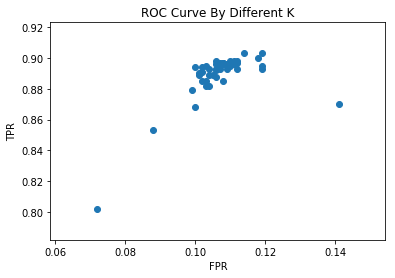

In [232]:
# Plot the ROC curve
plt.scatter(FPR_list, TPR_list)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve By Different K')

Suppose you work for a company that wants to figure out when a shirt appears among photos that have either shirts or pullovers. The company tells you that it cannot tolerate a false positive rate of detecting shirts that is more than 12.5%. What value of number of nearest neighbors $k$ achieves the highest true positive rate, but doesn't have more than a 12.5% false positive rate?

**Write your answer here:** 10

In [241]:
filter_idx = [idx for idx, FPR in enumerate(FPR_list) if FPR <= 0.125]
k = np.argmax(np.array(TPR_list)[filter_idx])
print('The corresponding k with highest TPR is: %d' % (k+1))

The corresponding k with highest TPR is: 10


# Part 3: Sentiment Analysis [40 points]

Download data from: http://www.andrew.cmu.edu/user/georgech/HW3-data.zip <br>

The folder contains:

- `train.csv`
- `test.csv`

In this problem, we look at predicting whether a tweet has positive or negative sentiment. We intentionally write this problem to be a bit open-ended to let you play with different neural net code yourself and also for you to compare against a classical baseline.

**(a) [5 points]** We first read in the tweet data. Read the data present in `train.csv` file. **Please do not change the filename. In particular, use a relative path, i.e., `./HW3-data/train.csv`**. Then do the following:

1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Print the number of positive and negative sentiment labels

Note: If you are using `open()`, you may have to set `encoding='iso8859'`.

In [124]:
import pandas as pd
import numpy as np
import random
train = pd.read_csv('./HW3-data/train.csv', usecols=[0,5], names=['label', 'sentiment'], encoding='iso8859')
test = pd.read_csv('./HW3-data/test.csv', usecols=[0,5], names=['label', 'sentiment'], encoding='iso8859')

# shuffle the train data and sub-sample to 5000 size
random.seed(0)
train_idx = list(range(len(train)))
random.shuffle(train_idx)
sub_train_idx = train_idx[:5000]

train_data = np.array(train['sentiment'])[sub_train_idx]
train_label = np.array(train['label'])[sub_train_idx].astype(int)

test_data = np.array(test['sentiment'])
test_label = np.array(test['label']).astype(int)


In [125]:
print('The number of positive labels: %d' % len(train_label[train_label == 1]))
print('The number of negative labels: %d' % len(train_label[train_label == 0]))

The number of positive labels: 2539
The number of negative labels: 2461


**(b) [25 points]** Modify the LSTM demo code from lecture to work with this Twitter dataset. Play with the learning rate and batch size so that the training gives reasonable increases in training and validation accuracies as we progress through epochs (leave the number of epochs at 10). Also feel free to try different neural net architectures (although you do not have to). What test accuracy are you able to achieve?

# Data Prepocessing

In [129]:
# Data preprocessing 
torch.manual_seed(0)
proper_train_size = int(len(train_data) * 0.8)
val_size = len(train_data) - proper_train_size
train_idx, val_idx = torch.utils.data.random_split(range(len(train_data)),[proper_train_size, val_size])
val_data = train_data[val_idx]
val_label = torch.tensor(train_label[val_idx])
train_data = train_data[train_idx]
train_label = torch.tensor(train_label[train_idx])

In [56]:
from torchnlp.encoders.text import SpacyEncoder

encoder = SpacyEncoder([data for data in train_data])
proper_train_encoded = [encoder.encode(data) for data in train_data]
val_encoded = [encoder.encode(data) for data in val_data]

proper_train_dataset_encoded = list(zip(proper_train_encoded, train_label))
val_dataset_encoded = list(zip(val_encoded, val_label))

# Encode the Data

In [58]:
from torchnlp.word_to_vector import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)

glove.6B.zip: 862MB [06:59, 2.05MB/s]                                
100%|██████████| 400000/400000 [00:21<00:00, 18385.63it/s]


torchnlp.word_to_vector.glove.GloVe

In [59]:
embedding_weights = torch.Tensor(encoder.vocab_size, pretrained_embedding.dim)
for i, token in enumerate(encoder.vocab):
    embedding_weights[i] = pretrained_embedding[token]

In [98]:
simple_lstm_model = nn.Sequential(nn.Embedding.from_pretrained(embedding_weights),
                                  UDA_LSTMforSequential(100, 64),
                                  nn.Linear(64, 2))
summary(simple_lstm_model, torch.zeros((1, 5), dtype=torch.long))

                Kernel Shape Output Shape   Params Mult-Adds
Layer                                                       
0_0             [100, 11577]  [1, 5, 100]        -         -
1_1.LSTM_model             -   [1, 5, 64]  42.496k   41.984k
2_2                  [64, 2]       [1, 2]    130.0     128.0
-------------------------------------------------------------
                         Totals
Total params          1.200326M
Trainable params        42.626k
Non-trainable params    1.1577M
Mult-Adds               42.112k


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[100, 11577]","[1, 5, 100]",NaN,NaN
1_1.LSTM_model,-,"[1, 5, 64]",42496.0,41984.0
2_2,"[64, 2]","[1, 2]",130.0,128.0


# Using Validation Data to Determine the Hyperparameter

In [103]:
parameter_set = [(lr, batch_size) for lr in [0.001, 0.01, 0.1] for batch_size in [64, 128, 256]]
accuracy = []
for parameter in parameter_set:
    num_epochs = 10  # during optimization, how many times we look at training data
    batch_size = parameter[1]  # during optimization, how many training data to use at each step
    learning_rate = parameter[0]  # during optimization, how much we nudge our solution at each step
    
    simple_lstm_model = nn.Sequential(nn.Embedding.from_pretrained(embedding_weights),
                                  UDA_LSTMforSequential(100, 64),
                                  nn.Linear(64, 2))
    train_accuracies, val_accuracies = \
        UDA_pytorch_classifier_fit(simple_lstm_model,
                                   torch.optim.Adam(simple_lstm_model.parameters(),
                                                    lr=learning_rate),
                                   nn.CrossEntropyLoss(),  # includes softmax
                                   proper_train_dataset_encoded, val_dataset_encoded,
                                   num_epochs, batch_size,  
                                   sequence=True)
    accuracy.append((train_accuracies, val_accuracies))

Epoch 1 [==================================================] 4000/4000
  Train accuracy: 0.5305
  Validation accuracy: 0.5180
Epoch 2 [==================================================] 4000/4000
  Train accuracy: 0.5695
  Validation accuracy: 0.5500
Epoch 3 [==================================================] 4000/4000
  Train accuracy: 0.5450
  Validation accuracy: 0.5310
Epoch 4 [==================================================] 4000/4000
  Train accuracy: 0.6210
  Validation accuracy: 0.5800
Epoch 5 [==================================================] 4000/4000
  Train accuracy: 0.6723
  Validation accuracy: 0.6190
Epoch 6 [==================================================] 4000/4000
  Train accuracy: 0.7340
  Validation accuracy: 0.6650
Epoch 7 [==================================================] 4000/4000
  Train accuracy: 0.6675
  Validation accuracy: 0.6290
Epoch 8 [==================================================] 4000/4000
  Train accuracy: 0.6138
  Validation accuracy:

Epoch 6 [==================================================] 4000/4000
  Train accuracy: 0.5503
  Validation accuracy: 0.5420
Epoch 7 [==================================================] 4000/4000
  Train accuracy: 0.5317
  Validation accuracy: 0.5260
Epoch 8 [==================================================] 4000/4000
  Train accuracy: 0.5570
  Validation accuracy: 0.5380
Epoch 9 [==================================================] 4000/4000
  Train accuracy: 0.5112
  Validation accuracy: 0.5070
Epoch 10 [==================================================] 4000/4000
  Train accuracy: 0.6198
  Validation accuracy: 0.5810
Epoch 1 [==================================================] 4000/4000
  Train accuracy: 0.4920
  Validation accuracy: 0.4820
Epoch 2 [==================================================] 4000/4000
  Train accuracy: 0.5095
  Validation accuracy: 0.5090
Epoch 3 [==================================================] 4000/4000
  Train accuracy: 0.5100
  Validation accuracy

Fig 1: Learning Rate: 0.001 Batch Size: 64
Fig 2: Learning Rate: 0.001 Batch Size: 128
Fig 3: Learning Rate: 0.001 Batch Size: 256
Fig 4: Learning Rate: 0.010 Batch Size: 64
Fig 5: Learning Rate: 0.010 Batch Size: 128
Fig 6: Learning Rate: 0.010 Batch Size: 256
Fig 7: Learning Rate: 0.100 Batch Size: 64
Fig 8: Learning Rate: 0.100 Batch Size: 128
Fig 9: Learning Rate: 0.100 Batch Size: 256


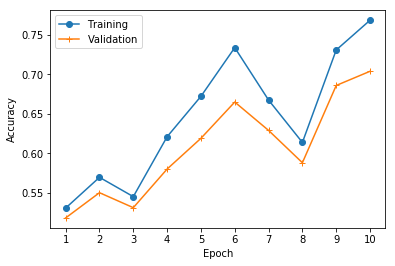

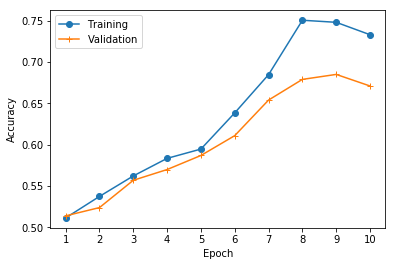

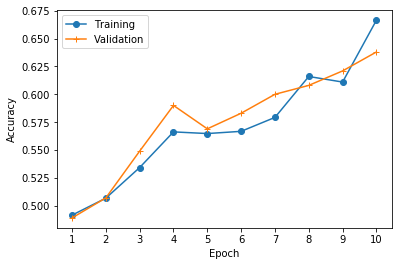

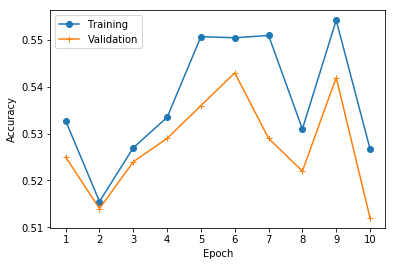

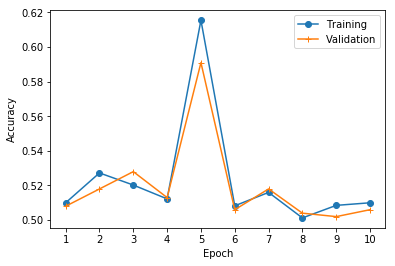

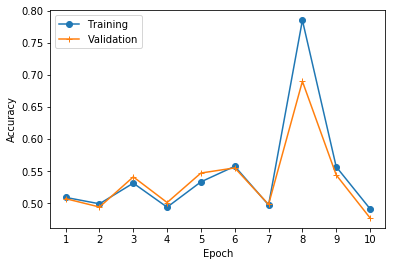

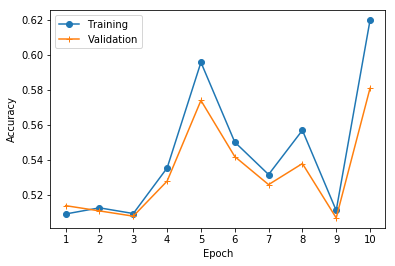

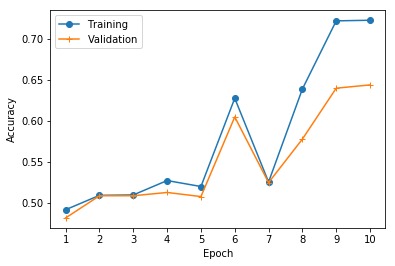

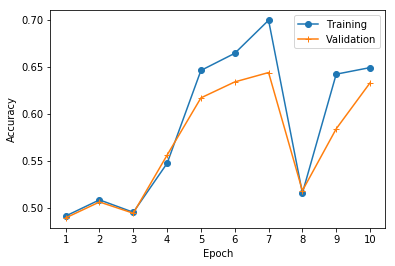

In [254]:
for idx, acc in enumerate(accuracy):
    print('Fig %d:' % (idx+1), 'Learning Rate: %.3f' % parameter_set[idx][0], 'Batch Size: %d' % parameter_set[idx][1])
    UDA_plot_train_val_accuracy_vs_epoch(acc[0], acc[1])

After comparing the figure, choosing learning rate=0.001 and batch size=128 as the best parameter.

Epoch 1 [==================================================] 4000/4000
  Train accuracy: 0.5118
  Validation accuracy: 0.5160
Epoch 2 [==================================================] 4000/4000
  Train accuracy: 0.5158
  Validation accuracy: 0.5150
Epoch 3 [==================================================] 4000/4000
  Train accuracy: 0.5365
  Validation accuracy: 0.5340
Epoch 4 [==================================================] 4000/4000
  Train accuracy: 0.5323
  Validation accuracy: 0.5320
Epoch 5 [==================================================] 4000/4000
  Train accuracy: 0.5530
  Validation accuracy: 0.5510
Epoch 6 [==================================================] 4000/4000
  Train accuracy: 0.5510
  Validation accuracy: 0.5530
Epoch 7 [==================================================] 4000/4000
  Train accuracy: 0.5593
  Validation accuracy: 0.5510
Epoch 8 [==================================================] 4000/4000
  Train accuracy: 0.6005
  Validation accuracy:

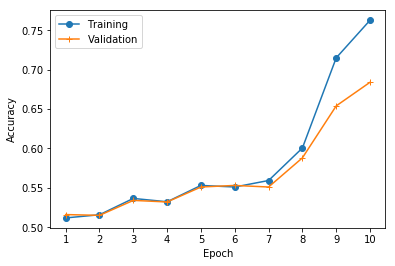

In [112]:
test_encoded = [encoder.encode(data) for data in test_data]

simple_lstm_model = nn.Sequential(nn.Embedding.from_pretrained(embedding_weights),
                                  UDA_LSTMforSequential(100, 64),
                                  nn.Linear(64, 2))
num_epochs = 10  # during optimization, how many times we look at training data
batch_size = 128  # during optimization, how many training data to use at each step
learning_rate = 0.001  # during optimization, how much we nudge our solution at each step

train_accuracies, val_accuracies = \
    UDA_pytorch_classifier_fit(simple_lstm_model,
                               torch.optim.Adam(simple_lstm_model.parameters(),
                                                lr=learning_rate),
                               nn.CrossEntropyLoss(),  # includes softmax
                               proper_train_dataset_encoded, val_dataset_encoded,
                               num_epochs, batch_size,
                               sequence=True)
UDA_plot_train_val_accuracy_vs_epoch(train_accuracies, val_accuracies)
predicted_test_labels = UDA_pytorch_classifier_predict(simple_lstm_model,
                                                       test_encoded,
                                                       sequence=True)
print('Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_label))

The test accuracy is around 59.2%

**(c) [10 points]** How well does an LSTM compare with using a classical classifier? To investigate this question, let's try training a random forest for sentiment analysis. Your code from part **(b)** should involve coming up with encoded representations of text, i.e., representing a tweet using a sequence of word indices. Use this to come up with a term frequency representation for each tweet. Feel free to remove stop words and/or apply TF-IDF weighting, and then feed the resulting feature vector representations for tweets to a random forest classifier. You can use cross-validation to select hyperparameters. Try to make the random forest classifier perform as well as possible (it is good practice in real-world applications to try to make baselines as good as possible rather than intentionally using a baseline with lousy hyperparameter choices; in particular, it is *bad* practice to tune hyperparameters carefully only on a method you're proposing while not tuning hyperparameters on baselines!). What test set accuracy are you able to achieve with the random forest?

In [211]:
train = pd.read_csv('./HW3-data/train.csv', usecols=[0,5], names=['label', 'sentiment'], encoding='iso8859')

# shuffle the train data and sub-sample to 5000 size
random.seed(0)
train_idx = list(range(len(train)))
random.shuffle(train_idx)
# using the same sub-dataset to compare the result
sub_train_idx = train_idx[:5000]

train_data = np.array(train['sentiment'])[sub_train_idx]
train_label = np.array(train['label'])[sub_train_idx].astype(int)

In [249]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", min_df=50, max_df=0.8)
train_X = vectorizer.fit_transform(train_data).toarray()

In [250]:
train_X.shape

(5000, 85)

In [214]:
hyperparameter_settings = [(num_trees, max_depth) for num_trees in range(50, 300, 50) for max_depth in (None, 4, 8, 12, 16)]
best_hyperparam_setting = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
    
for hyperparameter in hyperparameter_settings:
    fold_scores = []
    for train_indices, val_indices in k_fold.split(train_X):

        classifier = RandomForestClassifier(n_estimators=hyperparameter[0],
                                            max_depth=hyperparameter[1],
                                            random_state=0)
        classifier.fit(train_X[train_indices], train_label[train_indices])
        predicted_val_labels = classifier.predict(train_X[val_indices])
        score = np.mean(train_label[val_indices] != predicted_val_labels)
#         score = f1_score(train_label[val_indices], predicted_val_labels, average='weighted')
        fold_scores.append(score)
    

    cross_val_score = np.mean(fold_scores)
    print('hyperparameter: ', hyperparameter, ' ', cross_val_score)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparameter

print('Best hyperparameter setting:', best_hyperparam_setting)

hyperparameter:  (50, None)   0.3856
hyperparameter:  (50, 4)   0.39879999999999993
hyperparameter:  (50, 8)   0.39620000000000005
hyperparameter:  (50, 12)   0.395
hyperparameter:  (50, 16)   0.3896
hyperparameter:  (100, None)   0.3882
hyperparameter:  (100, 4)   0.40119999999999995
hyperparameter:  (100, 8)   0.3914
hyperparameter:  (100, 12)   0.39
hyperparameter:  (100, 16)   0.3822
hyperparameter:  (150, None)   0.38900000000000007
hyperparameter:  (150, 4)   0.394
hyperparameter:  (150, 8)   0.3872
hyperparameter:  (150, 12)   0.3902
hyperparameter:  (150, 16)   0.384
hyperparameter:  (200, None)   0.3894
hyperparameter:  (200, 4)   0.38780000000000003
hyperparameter:  (200, 8)   0.3876
hyperparameter:  (200, 12)   0.38820000000000005
hyperparameter:  (200, 16)   0.38360000000000005
hyperparameter:  (250, None)   0.39080000000000004
hyperparameter:  (250, 4)   0.3876
hyperparameter:  (250, 8)   0.38780000000000003
hyperparameter:  (250, 12)   0.3898
hyperparameter:  (250, 16)   

In [255]:
test_X = vectorizer.transform(test_data).toarray()

classifier = RandomForestClassifier(n_estimators=100,
                                            max_depth=4,
                                            random_state=0)
classifier.fit(train_X, train_label)
predicted_test_labels = classifier.predict(test_X)
accuracy = np.mean(test_label != predicted_test_labels)
# score = f1_score(test_label, predicted_val_labels, average='weighted')
print('Test accuracy:', accuracy)

Test accuracy: 0.570281124497992


The test accuracy is around 57.0%. Therefore, I consider the LSTM model to be better due to the higher accuracy. However, both of the results are relatively low, which is probably because the sample dataset is too small compared to the whole twitter reviews.